# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [ ]:
# stundent details example: John S. 9812
#                       student details 1: Shahar A. 3769
# (if exists)           student details 2: 
# (if exists)           student details 3: 
# (if exists)           student details 4: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: ChatGPT 5
Goal: Help organize the work flow, keep tabs on unfinished steps, and help with syntax errors.
Propmpt1: "Why do we set `random_state=42`, and what happens if we don’t fix a seed?"
    
Propmpt2: “Why would scaling make a difference if RandomForest is supposed to be scale-invariant?”
    
Propmpt3: “What’s the purpose of return_train_score=True in GridSearchCV, and when is it useful?”

</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
We’re working with housing data from California (1990 Census).  
The goal is to predict the median house value in each area.  
Prices are given in $100,000 units and are capped at $500,000, so very expensive homes aren’t shown fully.  

What we expect: areas with higher income and certain locations (like coastal cities) should have higher house prices.  
The project is about testing this idea, seeing which factors matter most, and finding the best model and params to predict prices on unseen data.    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load train and test sets
train_df = pd.read_csv("housing_train.csv")
test_df = pd.read_csv("housing_test.csv")

# Basic checks
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

display(train_df.head())
display(test_df.head())

#check missing values in dataset
def check_missing(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print(f"No missing values found in {name}.")
    else:
        print(f"Missing values in {name}:")
        print(missing)

check_missing(train_df, "Train set")
check_missing(test_df, "Test set")

#check for duplicate rows in train and test
dup_train = train_df.duplicated().sum()
dup_test = test_df.duplicated().sum()

print(f"Duplicates in train: {dup_train}")
print(f"Duplicates in test: {dup_test}")

Train shape: (16512, 9)
Test shape: (4128, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,5.3254,32.0,5.786260,1.033079,982.0,2.498728,34.29,-119.27,3.852
1,5.3032,52.0,5.095745,1.028369,980.0,3.475177,34.08,-118.12,2.457
2,4.1679,41.0,6.617486,1.371585,915.0,2.500000,37.05,-122.05,2.013
3,3.6429,28.0,5.249180,1.009836,848.0,2.780328,38.69,-121.41,1.052
4,2.7457,17.0,11.183267,2.107570,675.0,2.689243,38.88,-119.99,1.078


No missing values found in Train set.
No missing values found in Test set.
Duplicates in train: 0
Duplicates in test: 0


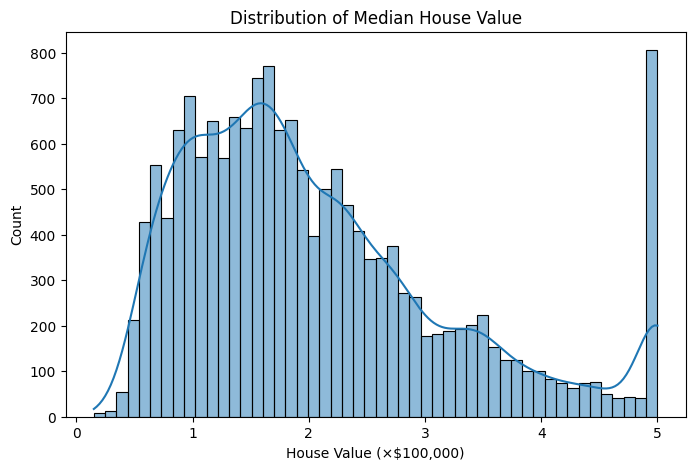

In [60]:
plt.figure(figsize=(8,5))
sns.histplot(train_df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of Median House Value")
plt.xlabel("House Value (×$100,000)")
plt.ylabel("Count")
plt.show()

#the below histplotshows how many houses are there per a median house value
#we can see the 500k$ count if huge, probably signifying a value cap in the dataset

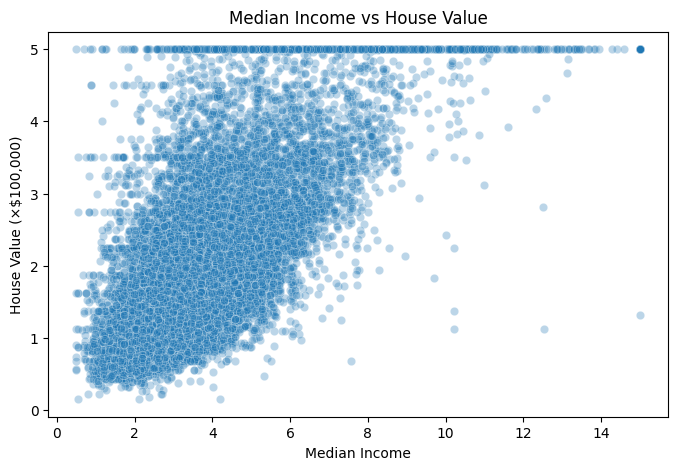

In [82]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="MedInc", y="MedHouseVal", data=train_df, alpha=0.3)
plt.title("Median Income vs House Value")
plt.xlabel("Median Income")
plt.ylabel("House Value (×$100,000)")
plt.show()

#the following plot shows how the median vlaue is spread across the median income (we will later see it is one of the most important factors)
#again we can see the cap at the 500k$ mark

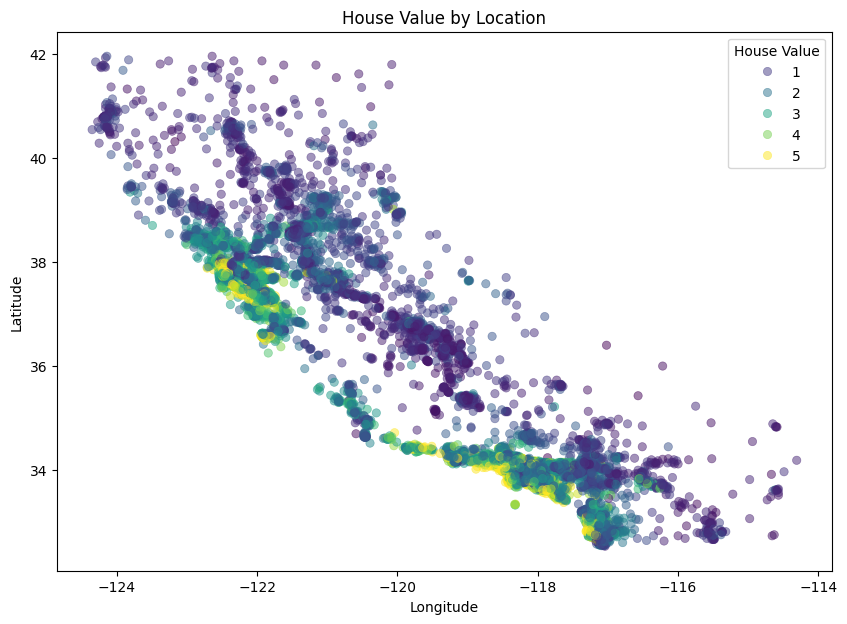

In [84]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="Longitude", y="Latitude",
    hue="MedHouseVal", palette="viridis",
    data=train_df, alpha=0.5, edgecolor=None
)
plt.title("House Value by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="House Value", loc="upper right")
plt.show()

#below we see a plot of median value by location (longXlat)
#we can see that the closer the house to the sea and high demand areas (San Francisco, LA, San Diego), the higher the median value

## Part 3 - Experiments
You could add as many code cells as needed

In [63]:
target = "MedHouseVal"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

In [64]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1) #algo of choice is Random Forest Regressor
pipe_scaled = Pipeline([("scaler", StandardScaler()),("model", rf)]) #Feature engineering is done by scaling
pipe_noscale = Pipeline([("identity", "passthrough"),("model", rf)])

param_grid_scaled = {"model__n_estimators": [100, 300],"model__max_depth": [None, 12],}
param_grid_noscale = {"model__n_estimators": [100, 300],"model__max_depth": [None, 12],}

cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [65]:
grid_scaled = GridSearchCV(pipe_scaled, param_grid_scaled, cv=cv, scoring="r2",n_jobs=-1, return_train_score=True, verbose=0)
grid_noscale = GridSearchCV(pipe_noscale, param_grid_noscale, cv=cv, scoring="r2",n_jobs=-1, return_train_score=True, verbose=0)

grid_scaled.fit(X_train, y_train);
grid_noscale.fit(X_train, y_train);

In [66]:
#Show top results for scaled pipeline
pd.DataFrame(grid_scaled.cv_results_).sort_values("rank_test_score")[[
    "mean_train_score", "mean_test_score", 
    "std_test_score", "rank_test_score",
    "param_model__n_estimators", "param_model__max_depth"
]].head()

,mean_train_score,mean_test_score,std_test_score,rank_test_score,param_model__n_estimators,param_model__max_depth
1,0.972782,0.802892,0.015509,1,300,None
0,0.972027,0.801212,0.015999,2,100,None
3,0.923738,0.792131,0.016062,3,300,12
2,0.923370,0.791492,0.016091,4,100,12


In [67]:
#Show top results for no-scale pipeline
pd.DataFrame(grid_noscale.cv_results_).sort_values("rank_test_score")[[
    "mean_train_score", "mean_test_score", 
    "std_test_score", "rank_test_score",
    "param_model__n_estimators", "param_model__max_depth"
]].head()

,mean_train_score,mean_test_score,std_test_score,rank_test_score,param_model__n_estimators,param_model__max_depth
1,0.972790,0.802849,0.015482,1,300,None
0,0.972027,0.801169,0.015947,2,100,None
3,0.923744,0.792105,0.016023,3,300,12
2,0.923372,0.791496,0.016037,4,100,12


In [86]:
if grid_scaled.best_score_>=grid_noscale.best_score_:
    best_score=grid_scaled.best_score_
    winner_fe="scaled"
    best_params=grid_scaled.best_params_
    final_pipe=pipe_scaled
else:
    best_score=grid_noscale.best_score_
    winner_fe="noscale"
    best_params=grid_noscale.best_params_
    final_pipe=pipe_noscale

print("Best feature-engineering choice:", winner_fe)
print("Best CV R²:", best_score)
print("Best params:", best_params)

Best feature-engineering choice: scaled
Best CV R²: 0.802891590564002
Best params: {'model__max_depth': None, 'model__n_estimators': 300}


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [69]:
final_pipe = final_pipe.set_params(**best_params)
final_pipe.fit(X_train, y_train);

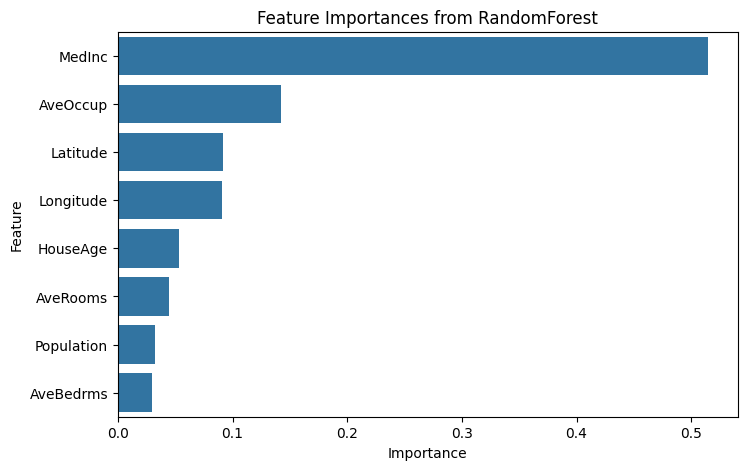

In [81]:
rf_model = final_pipe.named_steps["model"]  # get RF inside the pipeline
importances = rf_model.feature_importances_
features = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances from RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#The plot showing my intuition from before - median income is the most important factor when predicting median house value

## Part 5 - Apply on test and show model performance estimation

In [70]:
X_test = test_df.drop(columns=[target])
y_test = test_df[target]
y_pred_test = final_pipe.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
print(f"Test R²: {r2:.4f}")

Test R²: 0.8267


In [76]:
pd.DataFrame({"y_pred": y_pred_test, "y_true":y_test.values}).head()

,y_pred,y_true
0,3.387077,3.852
1,2.419610,2.457
2,2.615710,2.013
3,1.126983,1.052
4,1.209377,1.078


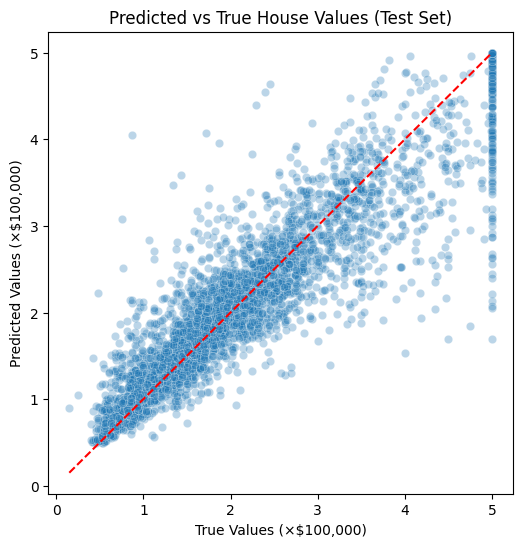

In [77]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45° line
plt.xlabel("True Values (×$100,000)")
plt.ylabel("Predicted Values (×$100,000)")
plt.title("Predicted vs True House Values (Test Set)")
plt.show()

#the plot showing the linear correlation between the predicted values and the actual values